In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
from sklearn.ensemble import RandomForestClassifier
import random
RAND_SEED = 2016 
random.seed(RAND_SEED) # change this to see new random data!

# Generating some sample data

Let's start by generating some random data. We need to set two features (xcoord and y_coord), a domain, and a label
for each instance

,x_coord,y_coord,domain_index,label
0,0.970959,-5.814882,2,False
1,2.219159,-0.787387,0,True
2,-4.629542,-5.087890,2,False
3,7.264013,1.475821,0,False
4,-8.582609,5.535371,2,True
5,5.535070,2.514871,1,False
6,3.883812,2.465593,1,False
7,-1.264045,9.674798,1,True
8,10.521706,-8.873840,0,True
9,5.376876,2.716703,1,True


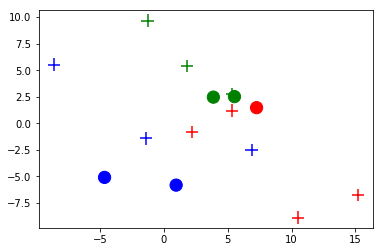

In [2]:
# randomly generate some data
X, domain_index = make_blobs(n_samples=15, centers=3, n_features=2, cluster_std=5)

# randomly assigning domain and label
all_instances = pd.DataFrame({"x_coord" : [x[0] for x in X],
              "y_coord" : [x[1] for x in X],
              "domain_index" : domain_index,
              "label" : [random.choice([True,False]) for _ in X]},
             columns = ['x_coord','y_coord','domain_index', 'label']
            )

# plotting
pos_instances = all_instances[all_instances.label == True]
neg_instances = all_instances[all_instances.label == False]
def add_series(instances, kw_args):
    color_list = ['red', 'green', 'blue']
    plt.scatter(instances.x_coord, 
                instances.y_coord, 
                s=[150 for _ in instances.iterrows()], 
                label=instances.domain_index,
                c=[color_list[i] for i in instances.domain_index],
                **kw_args
               )
    
add_series(pos_instances, {"marker": "+"})
add_series(neg_instances, {"marker": "o"})
all_instances

The domain is indicated by color.  The positive instances are designated by the plus sign and the negative instances are designated by the circle. 

# Dividing the data

The next step is to get some training and testing data.  Let's try and label three red domain instances.  We will designate these as test instances.  This has the following implications:

* The red domain is now the *target domain*
* The blue and green domains are the *source domains*
* All instances that are not in the three red domain *test instances* are *training instances*

Note that some of the training instances are in the target domain.  This represents having some available
training data for the domain you are trying to label.

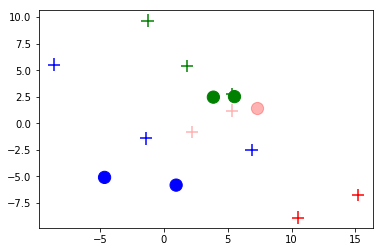

In [3]:
#arbitrarily set domain index 0 as target
test_set_domain = 0
# we are going to set the first three instances as test data
# note that this means that some of the target domain has training instances!
test_set = all_instances[all_instances.domain_index == test_set_domain].sample(3, random_state=RAND_SEED)
test_set_X = test_set.loc[:, ["x_coord", "y_coord"]].reset_index(drop=True)
test_set_y = test_set.loc[:, ["label"]].reset_index(drop=True)

# gather all non-test indexes 
train_pool = all_instances.iloc[all_instances.index.difference(test_set.index), ] 
train_pool_X = train_pool.loc[:, ["x_coord", "y_coord"]].reset_index(drop=True)
train_pool_y = train_pool["label"].reset_index(drop=True)
train_pool_domain = train_pool.domain_index

# now let's plot with test instances slightly transparent
# so all of the train instances are solid but the test instances are transparent

add_series(train_pool[train_pool.label == True], {"marker" : "+"})
add_series(train_pool[train_pool.label == False], {"marker" : "o"})
add_series(test_set[test_set.label == True], {"marker" : "+", "alpha" : .3})
add_series(test_set[test_set.label == False], {"marker" : "o", "alpha" : .3})

In the above figure, we see that there are 12 *training instances* (which are opaque and from all domains) and 3 *test instances* (which are transparent and from the red target domain).  

# Predicting Labels using Transfer Learning

We haven't used any of this libraries functionality yet. Let's give it a shot!  Now that we have the training and test data, we simply pass everything to one of the provided classes and call train_filter_test()

Let's start with the Source_Baseline class.  This simply uses all available *training source domain* data. This means that only blue and green domain training data are used.

In [4]:
from tl_algs import tl_baseline 

In [5]:
confidence, predicted_label = \
    tl_baseline.Source_Baseline(
                                test_set_X=test_set_X, 
                                test_set_domain=test_set_domain, 
                                train_pool_X=train_pool_X, 
                                train_pool_y=train_pool_y, 
                                train_pool_domain=train_pool_domain, 
                                Base_Classifier=RandomForestClassifier,
                                rand_seed=RAND_SEED
                               ) \
          .train_filter_test()
        
print("confidence")
print(str(confidence) + "\n\n")
print("predicted label")
print(predicted_label)

confidence
[0.20000000000000001, 0.59999999999999998, 0.40000000000000002]


predicted label
[False  True False]


We don't have much training data, but we got some predictions with confidence levels!

Let's try again with the Burak filter.

In [6]:
from tl_algs import burak

In [7]:
confidence, predicted_label = burak.Burak(
            test_set_X=test_set_X, 
            test_set_domain=test_set_domain, 
            train_pool_X=train_pool_X, 
            train_pool_y=train_pool_y, 
            train_pool_domain=train_pool_domain,
            cluster_factor = 15,
            k = 2,
            Base_Classifier=RandomForestClassifier,
            rand_seed=RAND_SEED
           ) \
    .train_filter_test()
    
        
print("confidence")
print(str(confidence) + "\n\n")
print("predicted label")
print(predicted_label)

confidence
[0.40000000000000002, 0.40000000000000002, 0.69999999999999996]


predicted label
[False False  True]


The process is very similar for all other transfer learning algorithms.

In [8]:
from tl_algs import peters, tnb, trbag

In [11]:
transfer_learners = [
    peters.Peters(test_set_X=test_set_X, 
                  test_set_domain=test_set_domain, 
                  train_pool_X=train_pool_X, 
                  train_pool_y=train_pool_y, 
                  train_pool_domain=train_pool_domain, 
                  cluster_factor=15,
                  Base_Classifier=RandomForestClassifier,
                  rand_seed=RAND_SEED
                 ),
    tnb.TransferNaiveBayes(test_set_X=test_set_X, 
                  test_set_domain=test_set_domain, 
                  train_pool_X=train_pool_X, 
                  train_pool_y=train_pool_y, 
                  train_pool_domain=train_pool_domain, 
                  rand_seed=RAND_SEED
                 ),
    trbag.TrBag(test_set_X=test_set_X, 
                  test_set_domain=test_set_domain, 
                  train_pool_X=train_pool_X, 
                  train_pool_y=train_pool_y, 
                  train_pool_domain=train_pool_domain, 
                  sample_size=test_set_y.shape[0],
                  Base_Classifier=RandomForestClassifier,
                  rand_seed=RAND_SEED
                 ),
    tl_baseline.Hybrid_Baseline(test_set_X=test_set_X, 
                  test_set_domain=test_set_domain, 
                  train_pool_X=train_pool_X, 
                  train_pool_y=train_pool_y, 
                  train_pool_domain=train_pool_domain, 
                  Base_Classifier=RandomForestClassifier,
                  rand_seed=RAND_SEED
                 ),
    tl_baseline.Target_Baseline(test_set_X=test_set_X, 
                  test_set_domain=test_set_domain, 
                  train_pool_X=train_pool_X, 
                  train_pool_y=train_pool_y, 
                  train_pool_domain=train_pool_domain, 
                  Base_Classifier=RandomForestClassifier,
                  rand_seed=RAND_SEED
                 )
]

for transfer_learner in transfer_learners:
    print(transfer_learner.train_filter_test())


([0.0, 0.10000000000000001, 0.10000000000000001], array([False, False, False], dtype=bool))
(array([ True,  True, False], dtype=bool), array([ 0.5017301 ,  0.50001189,  0.5       ]))


/Users/ashton/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


(array([ 0.71428571,  0.76190476,  0.71428571]), array([ True,  True,  True], dtype=bool))
([0.29999999999999999, 0.59999999999999998, 0.20000000000000001], array([False,  True, False], dtype=bool))
(array([ 1.,  1.,  1.]), array([ True,  True,  True], dtype=bool))


In [12]:
tl_baseline.Target_Baseline(test_set_X=test_set_X, 
                  test_set_domain=test_set_domain, 
                  train_pool_X=train_pool_X, 
                  train_pool_y=train_pool_y, 
                  train_pool_domain=train_pool_domain, 
                  Base_Classifier=RandomForestClassifier,
                  rand_seed=RAND_SEED
                 ).train_filter_test()

(array([ 1.,  1.,  1.]), array([ True,  True,  True], dtype=bool))